In [14]:
import matplotlib.pyplot as plt 
import pandas as pd
import random 
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression , Ridge
from sklearn.metrics import pairwise_distances
import numpy as np

exp_id = np.load('exp_id.npy')
exec(open("model_architecture.py").read())

net2 = torch.load('F'+ str(exp_id) +'_net2.pt')
deep_feat = torch.load('D1_F'+str(exp_id)+'_test_fusion_tensor.pt').double().to(device)

In [15]:
def get_proj (X,n,fn):
#   get projections of X
    ids_full = range(fn)
    N = np.zeros((n, fn))
    for i in range(n):
        tmp = X.copy()
        num_ids = random.randint(0,fn-1) #fn exclusive
        id_off = random.sample(ids_full, num_ids)
        tmp[id_off] = 0
        N[i] = tmp
    return N

def get_neigh(scaler, X, n, fn):
    samples = np.random.normal(0,1,n*fn).reshape(n,fn)
#     N = samples+X
#     N = (samples  - scaler.mean_)/scaler.scale_
    N = samples
    return(N)


def get_neigh2(X, n, fn):
    samples = np.random.multivariate_normal(X,np.eye(fn), n)
    N = samples
    return(N)


def dist(Z, X):
    sigma = X.shape[0]*0.75
    d = pairwise_distances(Z,X.reshape(1, -1),metric='euclidean').ravel()
    dist_weight = np.sqrt(np.exp(-(d ** 2) / sigma ** 2))   
    return(dist_weight)


In [16]:
fn=40
test_n = len(deep_feat)
W_pop_0 = np.zeros((test_n , fn))

net2.eval()
outputs = net2(deep_feat[:,0:10], deep_feat[:,10:20], deep_feat[:,20:40])

# Repeat Lime for all inputs 
for i in range(test_n):
    X = deep_feat[i].cpu().numpy()
    # Generate training data for Ridge
    n = 200
    N = get_neigh2(X, n, fn)
    Nt = torch.from_numpy(N).double().to(device)
    Y = net2(Nt[:, 0:10], Nt[:, 10:20], Nt[: , 20:40]) #prob for class 0 
    Y = Y.detach().cpu().numpy()
    w = dist(N,X)
    lime_ols =Ridge(alpha=1, random_state=10).fit(N,Y,sample_weight=w)
    W_pop_0[i,:] = lime_ols.coef_[0]

# Take average of absolute weights    
imp = np.mean(np.abs(W_pop_0), axis=0)

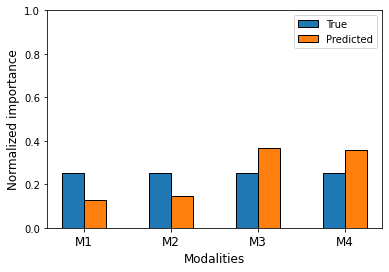

In [17]:
imp_m1 = np.sum(imp[0:10])/np.sum(imp)
imp_m2 = np.sum(imp[10:20])/np.sum(imp)
imp_m3 = np.sum(imp[20:30])/np.sum(imp)
imp_m4 = np.sum(imp[30:40])/np.sum(imp)

imp_m = np.array( [ imp_m1, imp_m2, imp_m3, imp_m4] ) 
imp_GT = np.load('F'+str(exp_id)+'_imp_gt.npy')

xlabel = ['M1', 'M2','M3','M4']
plt.bar([0-0.125,1-0.125,2-0.125,3-0.125], imp_GT,  edgecolor='k', width=0.25, capsize=2,  label='True')
plt.bar([0+0.125,1+0.125,2+0.125,3+0.125], imp_m,  edgecolor='k', width=0.25, capsize=2,  label='Predicted')
plt.xticks([0,1,2,3],xlabel,fontsize=12)
plt.xlabel('Modalities',fontsize=12)
plt.ylabel('Normalized importance',fontsize=12)
plt.ylim([0,1])
plt.legend()
plt.grid

np.save('F'+str(exp_id)+'_imp_lime', imp_m)